In [9]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import joblib

RANDOM_STATE = 42


In [10]:
DATA_PATH = "Crop_recommendation.csv"
df = pd.read_csv(DATA_PATH)
print(df.shape)
display(df.head())
df.info()
df.describe().T


(2200, 10)


,Nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall,label,Unnamed: 8,Unnamed: 9
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,NaN,NaN
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,NaN,NaN
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,NaN,NaN
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,NaN,NaN
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   phosphorus   2200 non-null   int64  
 2   potassium    2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
 8   Unnamed: 8   0 non-null      float64
 9   Unnamed: 9   0 non-null      float64
dtypes: float64(6), int64(3), object(1)
memory usage: 172.0+ KB


,count,mean,std,min,25%,50%,75%,max
Nitrogen,2200.0,50.551818,36.917334,0.000000,21.000000,37.000000,84.250000,140.000000
phosphorus,2200.0,53.362727,32.985883,5.000000,28.000000,51.000000,68.000000,145.000000
potassium,2200.0,48.149091,50.647931,5.000000,20.000000,32.000000,49.000000,205.000000
temperature,2200.0,25.616244,5.063749,8.825675,22.769375,25.598693,28.561654,43.675493
humidity,2200.0,71.481779,22.263812,14.258040,60.261953,80.473146,89.948771,99.981876
ph,2200.0,6.469480,0.773938,3.504752,5.971693,6.425045,6.923643,9.935091
rainfall,2200.0,103.463655,54.958389,20.211267,64.551686,94.867624,124.267508,298.560117
Unnamed: 8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


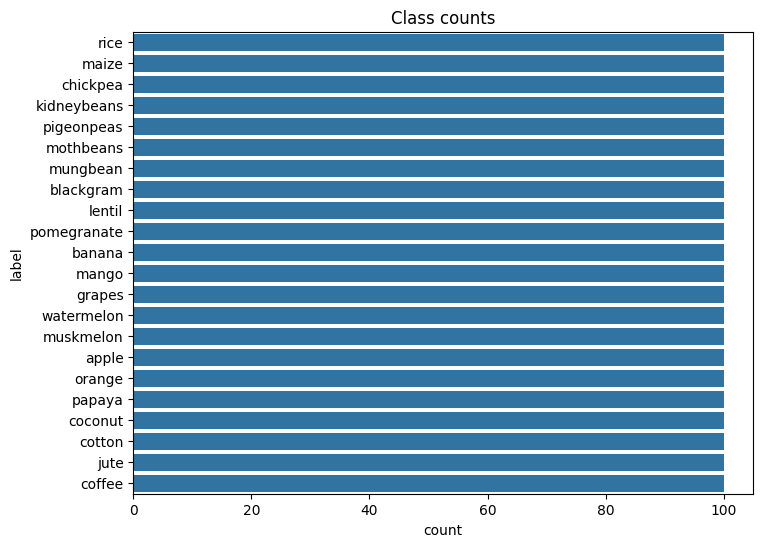

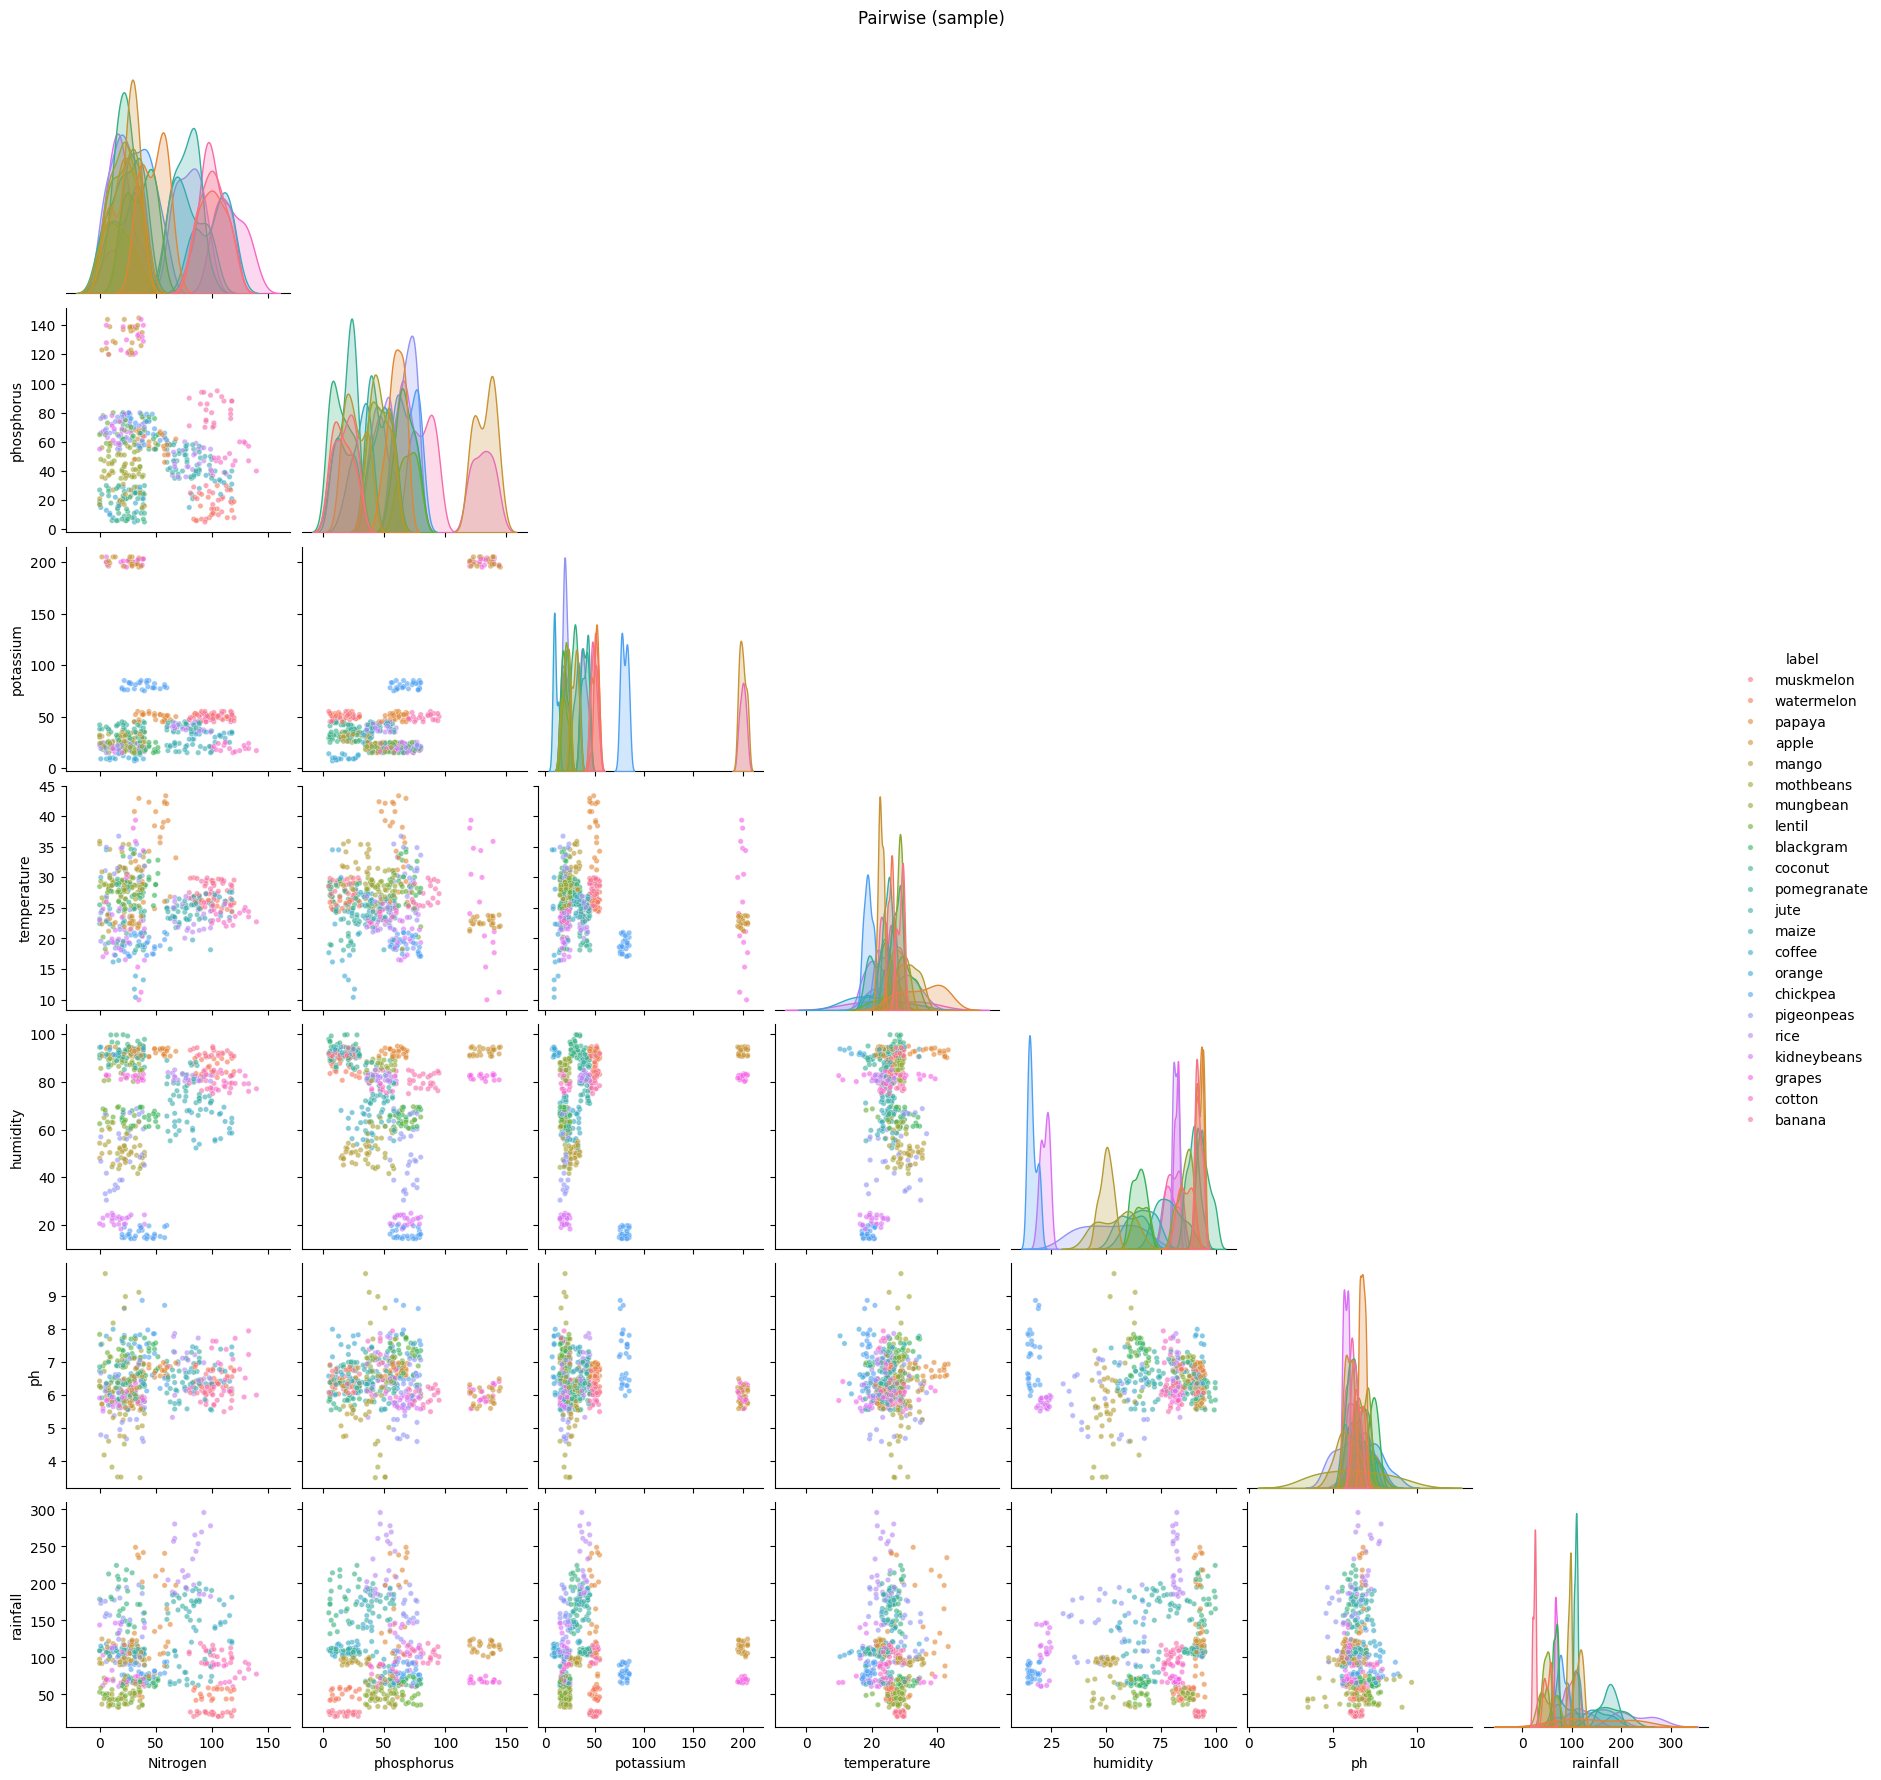

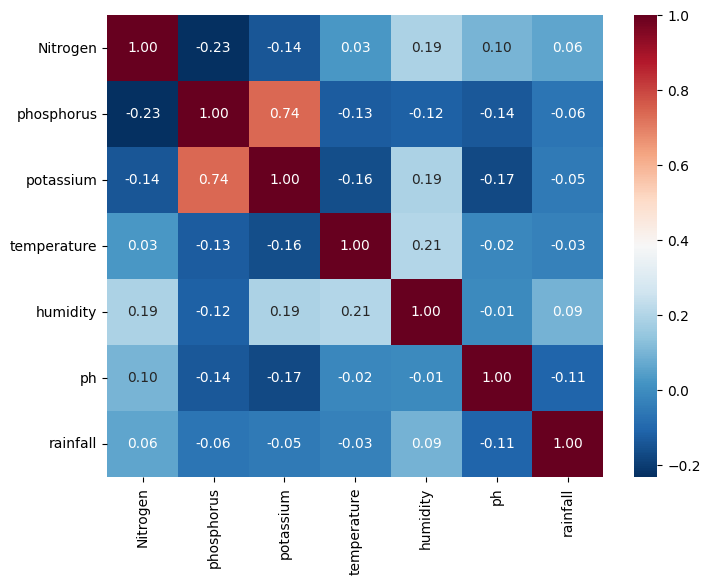

In [12]:
# class balance
plt.figure(figsize=(8,6))
sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
plt.title("Class counts")
plt.show()

# Sample for pairplot (don't run on full dataset)
sample = df.sample(n=500, random_state=RANDOM_STATE)
sns.pairplot(sample, vars=['Nitrogen','phosphorus','potassium','temperature','humidity','ph','rainfall'], hue='label', corner=True, plot_kws={'s':15,'alpha':0.6})
plt.suptitle("Pairwise (sample)", y=1.02)
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['Nitrogen','phosphorus','potassium','temperature','humidity','ph','rainfall']].corr(), annot=True, fmt='.2f', cmap='RdBu_r')
plt.show()


In [13]:
# create ratios and interaction features
df['N_ratio'] = df['Nitrogen'] / (df['Nitrogen']+df['phosphorus']+df['potassium'] + 1e-9)
df['P_ratio'] = df['phosphorus'] / (df['Nitrogen']+df['phosphorus']+df['potassium'] + 1e-9)
df['K_ratio'] = df['potassium'] / (df['Nitrogen']+df['phosphorus']+df['potassium'] + 1e-9)
df['N_x_rain'] = df['Nitrogen'] * df['rainfall']

feature_cols = ['Nitrogen','phosphorus','potassium','temperature','humidity','ph','rainfall','N_ratio','P_ratio','K_ratio','N_x_rain']
X = df[feature_cols].copy()
y = df['label'].copy()

le = LabelEncoder()
y_enc = le.fit_transform(y)
display(pd.Series(y_enc).value_counts())


20    100
11    100
3     100
9     100
18    100
13    100
14    100
2     100
10    100
19    100
1     100
12    100
7     100
21    100
15    100
0     100
16    100
17    100
4     100
6     100
8     100
5     100
Name: count, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape)


(1760, 11) (440, 11)


In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
hist_gb = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

print("RF CV:", cross_val_score(rf, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1).mean())
print("HistGB CV:", cross_val_score(hist_gb, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1).mean())


RF CV: 0.9920454545454545
HistGB CV: 0.9909090909090909


In [16]:
# Use RandomizedSearchCV to explore larger space quickly
pipe = Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])

param_dist = {
    'clf__n_estimators': [100,200,400,800],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2,5,10],
    'clf__min_samples_leaf': [1,2,4],
    'clf__max_features': ['sqrt', 0.6, 0.8]
}

from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(pipe, param_dist, n_iter=20, cv=skf, scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE, verbose=2)
%time rs.fit(X_train, y_train)
print("Best score:", rs.best_score_)
print("Best params:", rs.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 7.27 s
Wall time: 1min 39s
Best score: 0.9920454545454545
Best params: {'clf__n_estimators': 400, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 30}


In [17]:
# If RandomizedSearch found good region, refine with GridSearchCV
best = rs.best_params_
# build small grid using best (example shown)
grid = {
    'clf__n_estimators': [best['clf__n_estimators'], best['clf__n_estimators']*2],
    'clf__max_depth': [best['clf__max_depth'], None],
    'clf__min_samples_leaf': [best['clf__min_samples_leaf']],
}
gs = GridSearchCV(pipe, grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=2)
%time gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: total: 13.7 s
Wall time: 21.8 s
0.9920454545454545 {'clf__max_depth': 30, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 800}


Test acc: 0.9931818181818182
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       0.95      1.00      0.98        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.95      1.00      0.98        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00        2

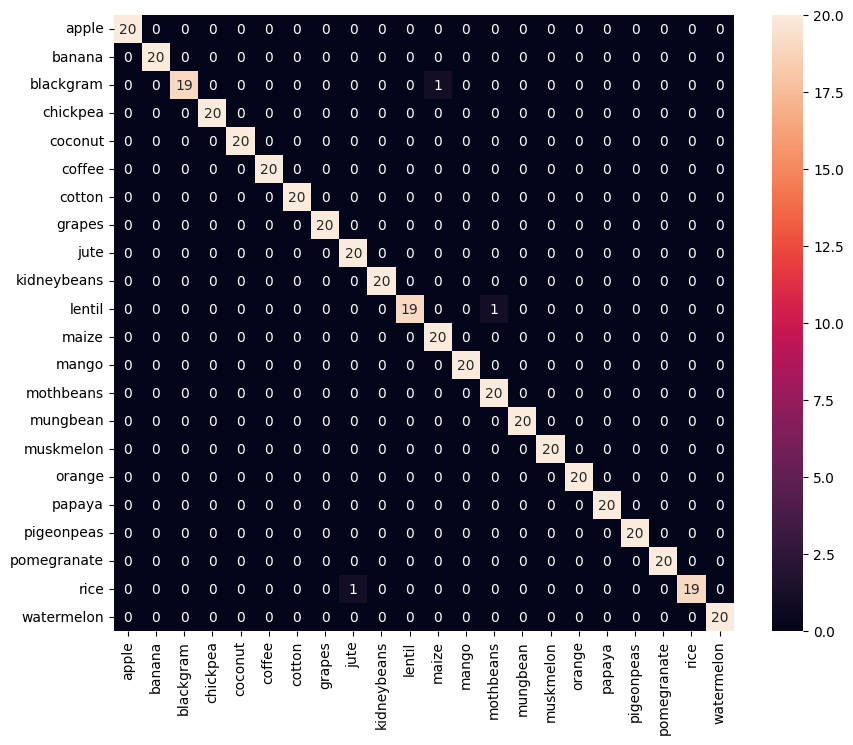

humidity       0.193071
rainfall       0.188739
potassium      0.134436
phosphorus     0.117161
Nitrogen       0.066044
N_x_rain       0.064060
K_ratio        0.063833
temperature    0.050401
N_ratio        0.044259
P_ratio        0.044211
ph             0.033784
dtype: float64

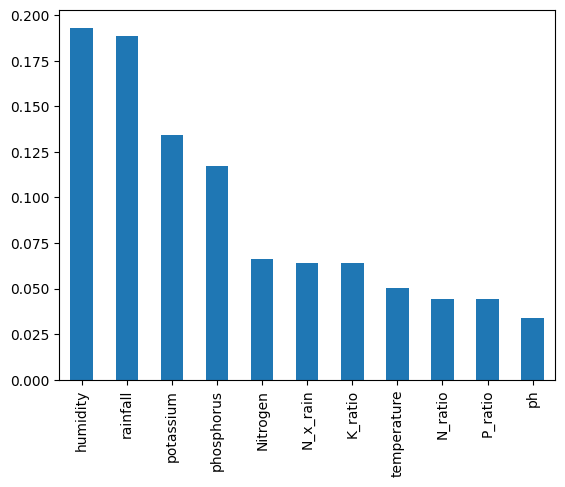

['label_encoder.joblib']

In [18]:
best_model = gs.best_estimator_ if 'gs' in globals() else rs.best_estimator_
y_pred = best_model.predict(X_test)
print("Test acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()

# Feature importances (if applicable)
clf = best_model.named_steps['clf']
if hasattr(clf, 'feature_importances_'):
    fi = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    display(fi)
    fi.plot(kind='bar'); plt.show()

# Save
joblib.dump(best_model, "crop_recommender_model.joblib")
joblib.dump(le, "label_encoder.joblib")
